In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
warnings.filterwarnings('ignore')

# 读取数据
df = pd.read_csv('识别结果/充电信息.csv', encoding='gbk')

df['demand'] = df['esoc']-df['ssoc']
#仅保留需求大于0的
df = df[df['demand']>0]


df = gpd.GeoDataFrame(df)
df['geometry'] = gpd.points_from_xy(df['slon'],df['slat'])

#转为投影坐标系，墨卡托坐标系，xy坐标的单位为米
df.crs = 'epsg:4326'
df_mercator = df.to_crs(epsg=21480)

In [4]:
#读取区域范围
area = gpd.read_file('gis/jiading_polygon.shp')

In [6]:
area.crs = 'epsg:4326'
area_mercator = area.to_crs(epsg=21480)
area_mercator.area/1000000

0    86.800493
dtype: float64

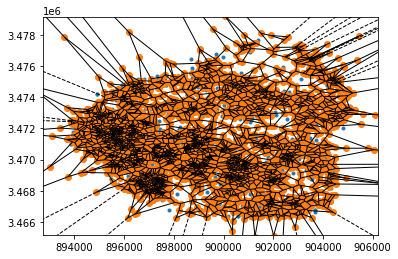

In [2]:
import numpy as np

#整理中心点信息
points = np.array([df_mercator.centroid.x.values,
                   df_mercator.centroid.y.values]).T
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import matplotlib.pyplot as plt

# 计算指定点的泰森多边形
vor = Voronoi(points)
# 绘制泰森多边形二维图像
fig = voronoi_plot_2d(vor)
plt.show()

In [3]:
from sklearn.cluster import AgglomerativeClustering

#通过调整dis调整聚类大小
def Hierarchical_Clustering(X,dis=8000):
    # 计算欧氏距离，不同聚类间合并的类方差最小化
    model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='complete',distance_threshold=dis)
    model = model.fit(X)
    Y_pred = model.fit_predict(X)

    
    return Y_pred

rescue_level=np.array(df['demand'])



In [4]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString,Polygon,MultiPolygon
import shapely
#整理中心点信息
points = np.array([df_mercator.centroid.x.values,
                   df_mercator.centroid.y.values]).T

In [5]:
Y_pred = Hierarchical_Clustering(points,2721)
#统计Y_pred中有多少个类别
def count_class(Y_pred):
    class_list = []
    for i in Y_pred:
        if i not in class_list:
            class_list.append(i)
    return class_list
len(count_class(Y_pred))

30

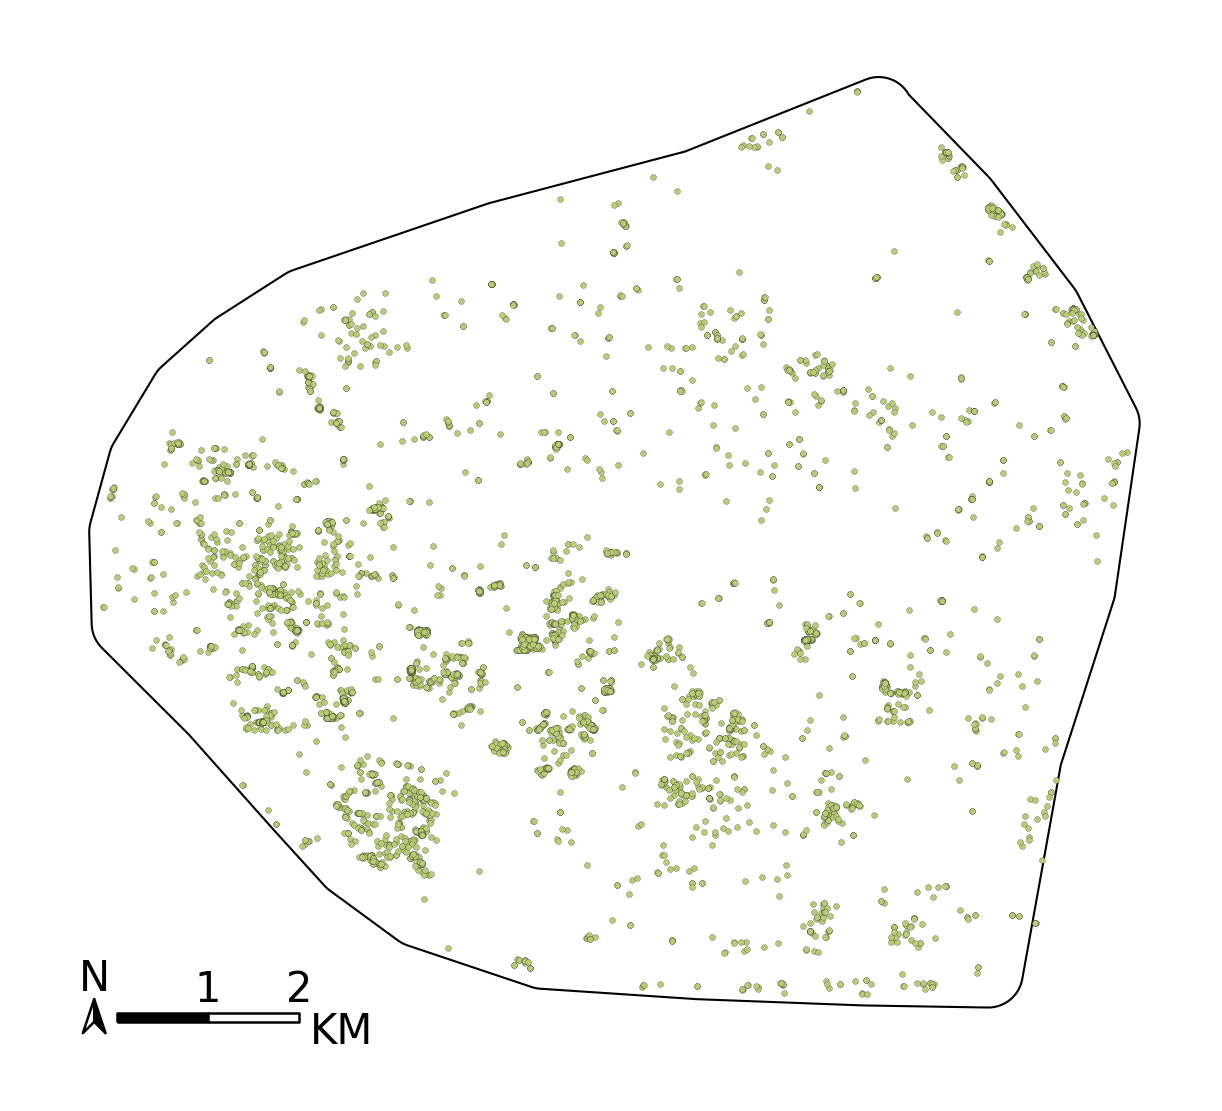

In [45]:
points_gdf = gpd.GeoDataFrame(points,columns=['x','y'])
points_gdf['class'] = Y_pred
points_gdf['geometry'] = gpd.points_from_xy(points_gdf['x'],points_gdf['y'])
points_gdf.crs = 'epsg:21480'
points_gdf_4326 = points_gdf.to_crs(epsg=4326)

#读取区域范围
area = gpd.read_file('gis/jiading_polygon.shp')

# 创建图框
import matplotlib.pyplot as plt
fig = plt.figure(1, (5, 5), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)
#points_gdf_4326.plot(column='class',cmap='tab20b',ax = ax,markersize=1,linewidth=0.1)
area.buffer(0.004).plot(facecolor='none',edgecolor='black',ax = ax,linewidth=0.5)
points_gdf_4326.plot(ax = ax,markersize=2,edgecolor='black',linewidth=0.05,color='#bacb76')
plt.axis('off')
import transbigdata as tbd
tbd.plotscale(ax, bounds=(121.12930802779142, 31.24250318985889, 121.26049570436622, 31.35993614038349), textsize=10, compasssize=1,accuracy=250,unit = 'KM',style = 2, rect=[0.06, 0.03])
plt.show()

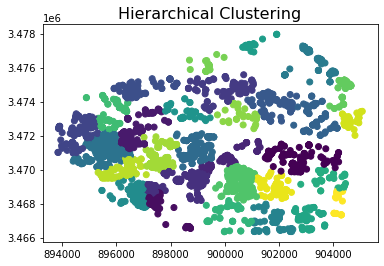

In [6]:

df_mercator['group'] = Y_pred
plt.figure('Hierarchical Clustering')
plt.title('Hierarchical Clustering', fontsize=16)
plt.tick_params(labelsize=10)
plt.scatter(points[:,0], points[:,1], c=Y_pred)

In [47]:
#研究区域边界
area = Polygon([[points[:, 0].min(), points[:, 1].min()],
         [points[:, 0].max(), points[:, 1].min()],
         [points[:, 0].max(), points[:, 1].max()],
         [points[:, 0].min(), points[:, 1].max()],
         ])

<AxesSubplot:>

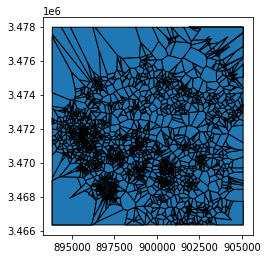

In [48]:
# 计算指定点的泰森多边形
vor = Voronoi(points)
# 生成泰森多边形的polygon
lines = [
    LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]
lines.append(area)
vor_gdf = gpd.GeoDataFrame()
vor_gdf['geometry'] = list(shapely.ops.polygonize(lines))
#提取所有边界线
bounds = vor_gdf.geometry.exterior.unary_union
#构成多边形
vor_polys = list(shapely.ops.polygonize(bounds))
vor_gdf = gpd.GeoDataFrame(geometry=vor_polys)
vor_gdf['id'] = range(len(vor_gdf))
#将多边形与点空间连接
vor_gdf.crs = df_mercator.crs
vor_gdf = gpd.sjoin(vor_gdf,df_mercator)
vor_gdf.plot(edgecolor = 'k')

In [50]:
vor_gdf.crs = 'epsg:21480'
vor_gdf_4326 = vor_gdf.to_crs(epsg=4326)

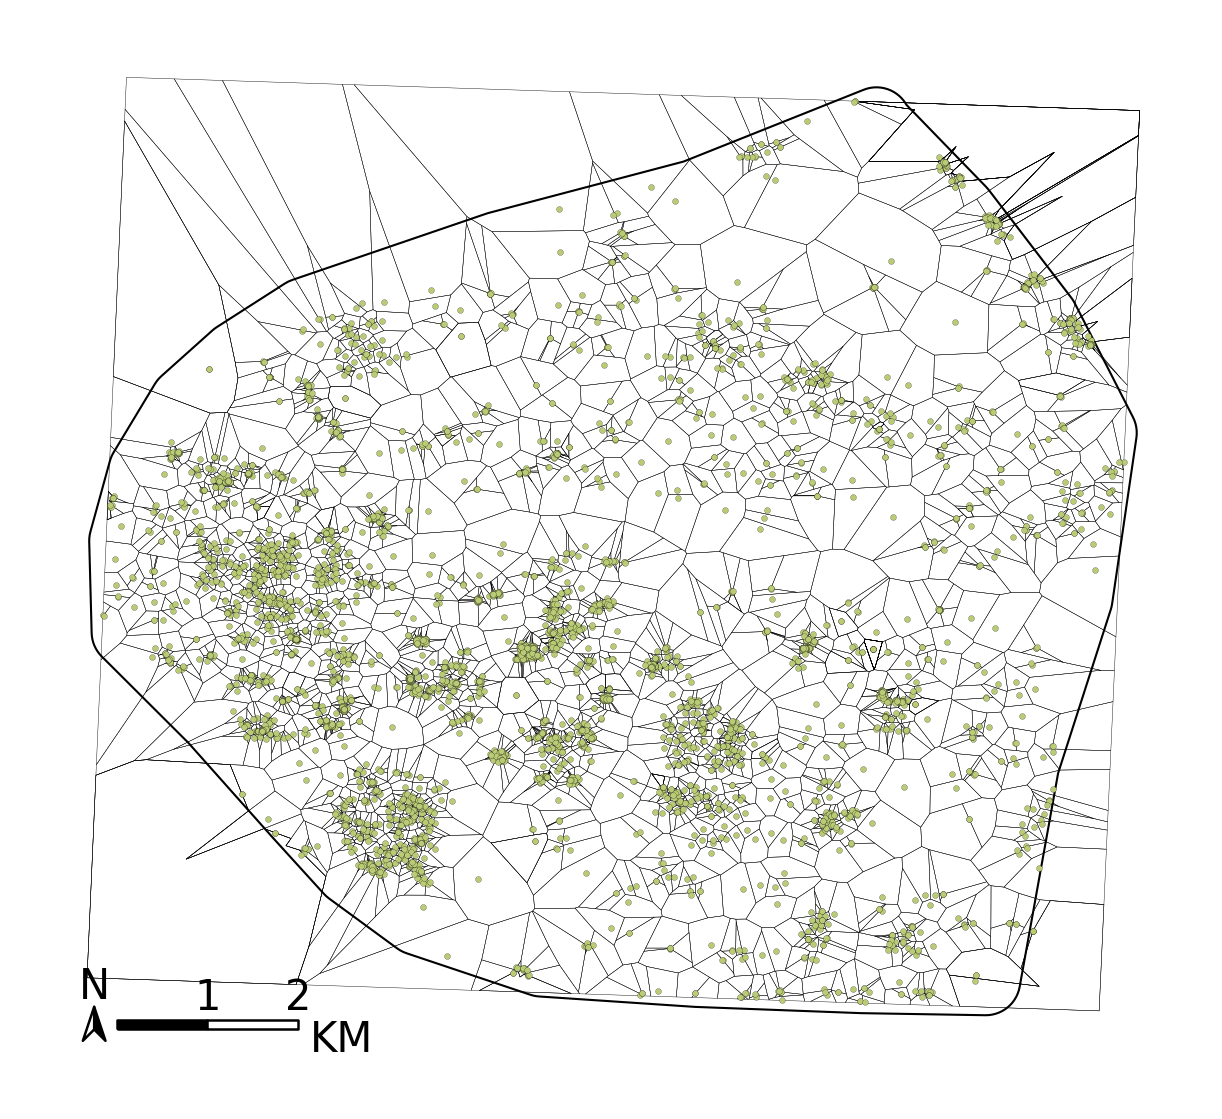

In [58]:
points_gdf = gpd.GeoDataFrame(points,columns=['x','y'])
points_gdf['class'] = Y_pred
points_gdf['geometry'] = gpd.points_from_xy(points_gdf['x'],points_gdf['y'])
points_gdf.crs = 'epsg:21480'
points_gdf_4326 = points_gdf.to_crs(epsg=4326)

#读取区域范围
area = gpd.read_file('gis/jiading_polygon.shp')

# 创建图框
import matplotlib.pyplot as plt
fig = plt.figure(1, (5, 5), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)
#points_gdf_4326.plot(column='class',cmap='tab20b',ax = ax,markersize=1,linewidth=0.1)
vor_gdf_4326.plot(ax = ax,markersize=2,edgecolor='black',linewidth=0.1,color='none')
area.buffer(0.004).plot(facecolor='none',edgecolor='black',ax = ax,linewidth=0.5)
points_gdf_4326.plot(ax = ax,markersize=2,edgecolor='black',linewidth=0.05,color='#bacb76')
plt.axis('off')
import transbigdata as tbd
tbd.plotscale(ax, bounds=(121.12930802779142, 31.24250318985889, 121.26049570436622, 31.35993614038349), textsize=10, compasssize=1,accuracy=250,unit = 'KM',style = 2, rect=[0.06, 0.03])
plt.show()

<AxesSubplot:>

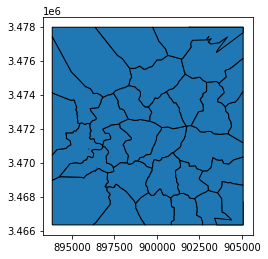

In [59]:
# 按标签聚合面
vor_gdf_agg = vor_gdf.groupby('group').apply(lambda r: MultiPolygon(
    list(r['geometry'])).buffer(0)).rename('geometry').reset_index()
vor_gdf_agg = gpd.GeoDataFrame(vor_gdf_agg)
vor_gdf_agg.plot(edgecolor = 'k')

In [60]:
#读取区域范围
area = gpd.read_file('gis/jiading_polygon.shp')

In [61]:
#将坐标系转为wgs84
vor_gdf_agg.crs = 'epsg:21480'
#用area裁剪vor_gdf_agg
vor_gdf_agg = gpd.clip(vor_gdf_agg.to_crs(epsg=4326),area)


In [62]:
len(vor_gdf_agg)

30

<AxesSubplot:>

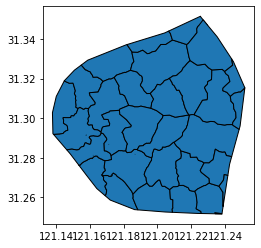

In [63]:
vor_gdf_agg.plot(edgecolor = 'k')

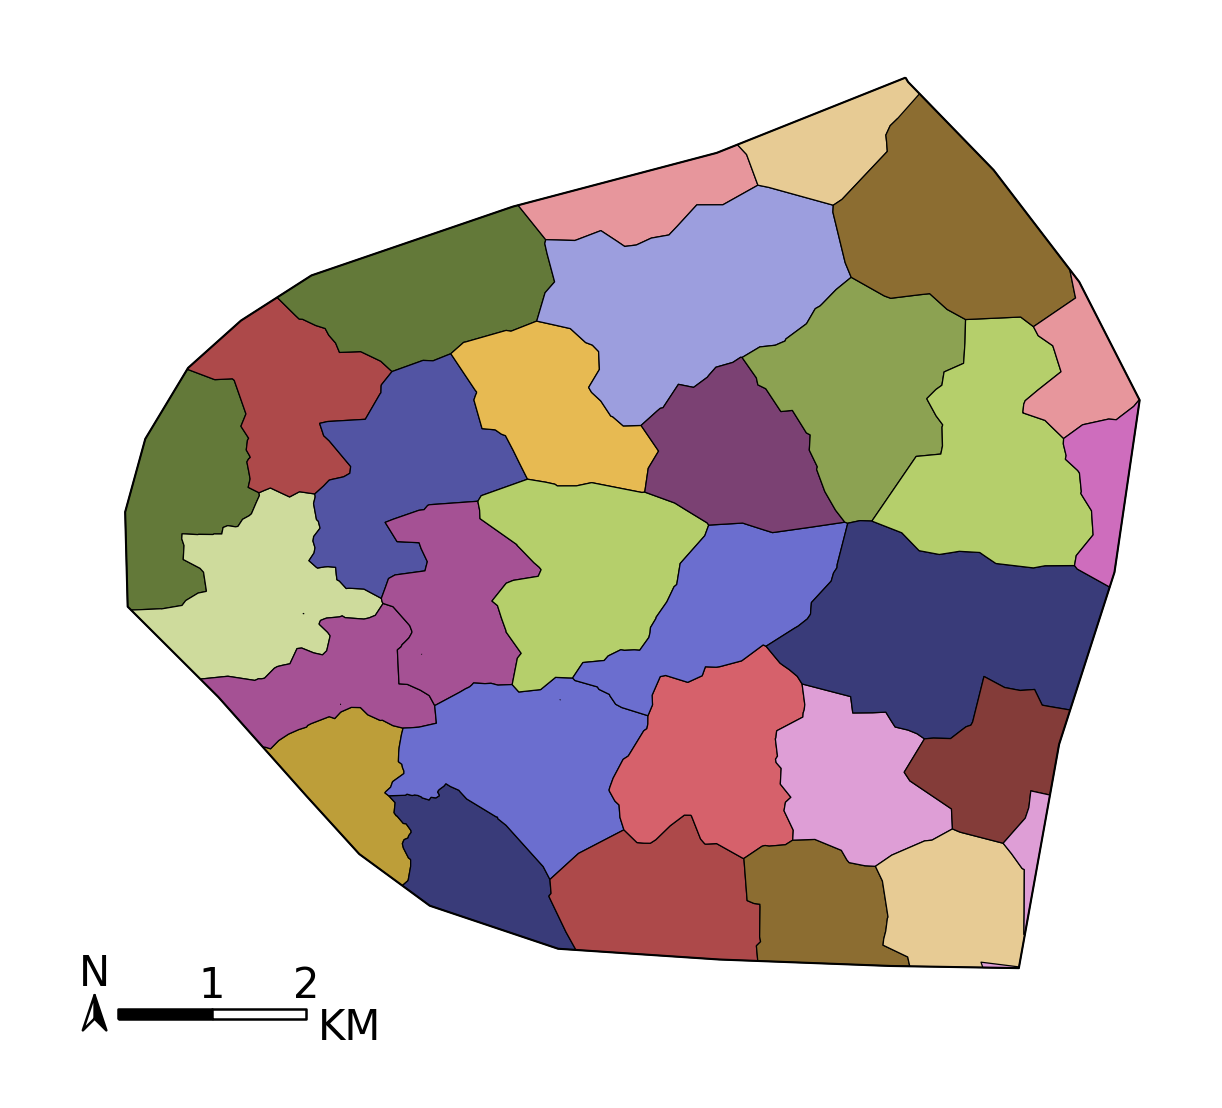

In [85]:

# 创建图框
import matplotlib.pyplot as plt
fig = plt.figure(1, (5, 5), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)
vor_gdf_agg.plot(column='group',cmap='tab20b',ax = ax,markersize=1,edgecolor = '#000',linewidth=0.3)
#vor_gdf_4326.plot(ax = ax,markersize=2,edgecolor='black',linewidth=0.1,color='none')
area.plot(facecolor='none',edgecolor='black',ax = ax,linewidth=0.5)
#points_gdf_4326.plot(ax = ax,markersize=2,edgecolor='black',linewidth=0.05,color='#bacb76')
plt.axis('off')
import transbigdata as tbd
tbd.plotscale(ax, bounds=(121.12930802779142, 31.24250318985889, 121.26049570436622, 31.35993614038349), textsize=10, compasssize=1,accuracy=250,unit = 'KM',style = 2, rect=[0.06, 0.03])
plt.show()

In [63]:
vor_gdf['demand'] = vor_gdf['esoc']- vor_gdf['ssoc']

0.00027331323324819297


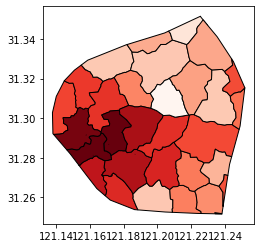

In [64]:
#区域救援等级=log(救援点*救援点救援等级/区域面积)
vor_gdf_agg['demand']=np.log(vor_gdf.groupby('group').apply(lambda r: sum(r['demand']))/vor_gdf_agg.area)
vor_gdf_agg.plot(edgecolor='k',column='demand',cmap='Reds')
print(sum(vor_gdf_agg.area)/vor_gdf_agg.shape[0])

In [68]:
vor_gdf_agg['x'] = vor_gdf_agg.centroid.x
vor_gdf_agg['y'] = vor_gdf_agg.centroid.y

In [69]:
vor_gdf_agg.to_file('分区结果/充电区域.json',driver='GeoJSON')

# 统计每个区域的充电需求

In [74]:
#读取区域范围
vor_gdf_agg = gpd.read_file('分区结果/充电区域.json')

#读取充电需求数据
demand = pd.read_csv('识别结果/负荷曲线.csv')


bounds = (120.85, 30.67, 122.24, 31.87)
#Obtain the gridding parameters
params = tbd.area_to_params(bounds,accuracy = 100)

#Create the grid
demand['geometry'] = tbd.grid_to_polygon([demand['LONCOL'],demand['LATCOL']],params)

In [76]:
demand = gpd.GeoDataFrame(demand)

In [103]:
area_demand = gpd.sjoin(demand,vor_gdf_agg).groupby(['group','hour'])['power'].sum().reset_index()

In [104]:
area_demand = pd.merge(area_demand,vor_gdf_agg)

In [105]:
area_demand = gpd.GeoDataFrame(area_demand)

In [109]:
len(area_demand['group'].drop_duplicates())

30

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


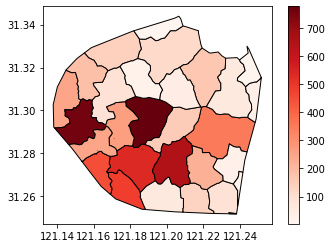

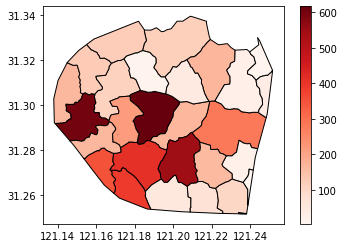

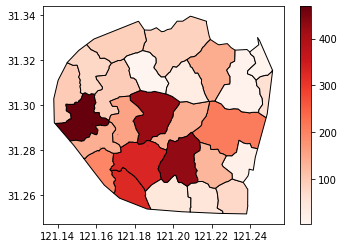

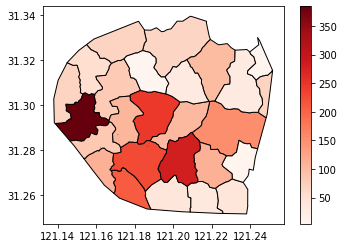

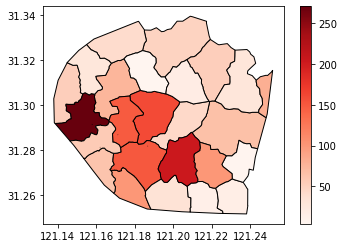

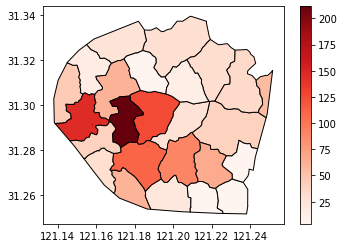

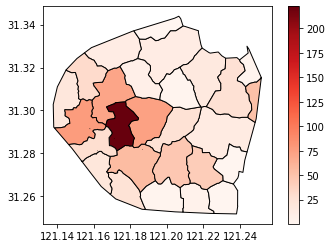

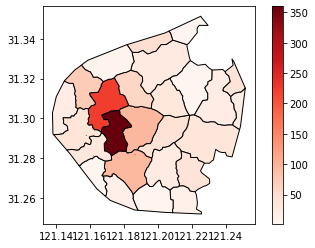

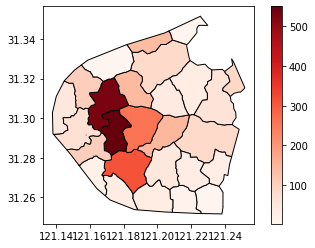

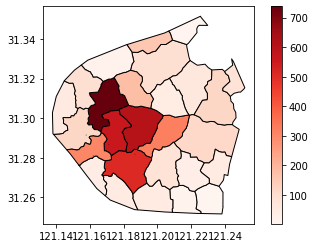

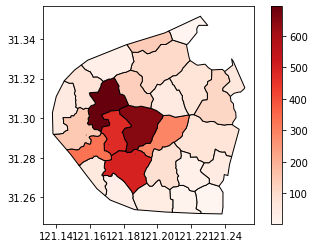

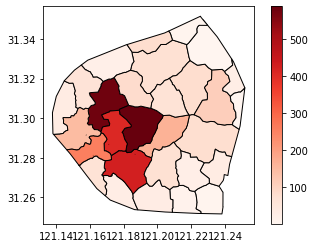

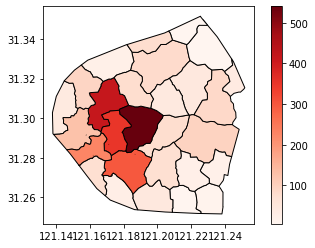

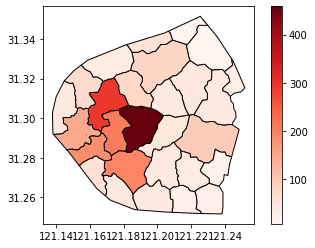

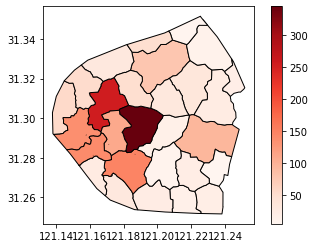

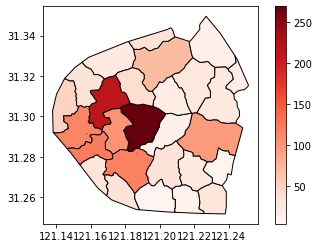

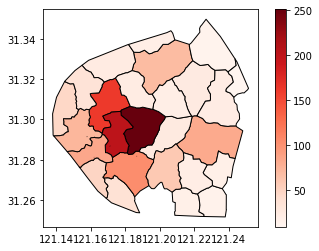

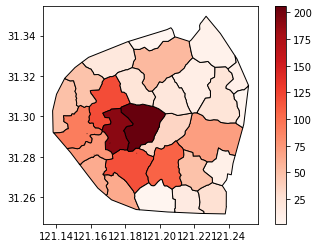

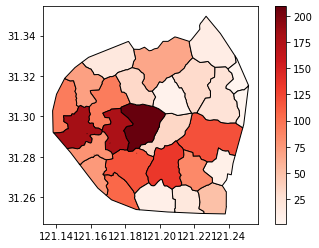

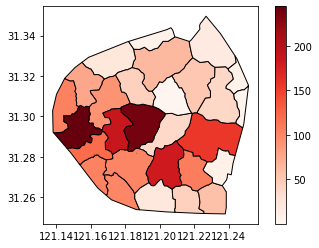

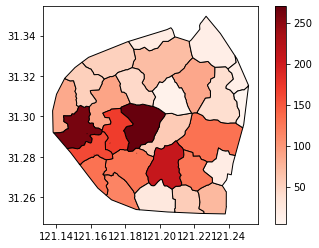

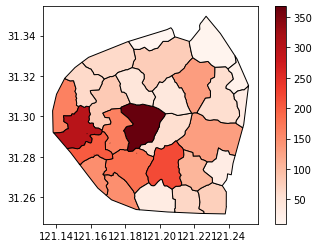

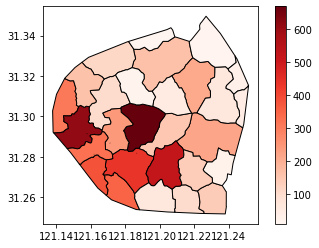

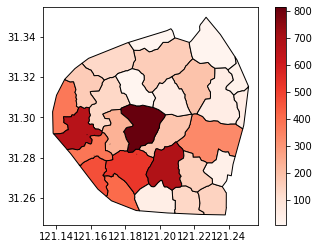

In [106]:
for i in range(24):
    print(i)
    area_demand[area_demand['hour']==i].plot(edgecolor='k',column='power',cmap='Reds',legend=True)

In [111]:
area_demand[['group','hour','power']].to_csv('分区结果/充电区域负荷.csv',index=False)

In [3]:
#读取区域范围
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd
import warnings
warnings.filterwarnings('ignore')
vor_gdf_agg = gpd.read_file('分区结果/充电区域.json')
vor_gdf_agg.to_csv('分区结果/充电区域.csv',index=False)